In [1]:
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

On cherche à résoudre
\begin{gather*}
    \max_{\phi \in \mathcal{M}_{n,m}(\mathbb{R})} \sum_{i = 1}^{n} \sum_{j = 1}^{m} \phi_{i,j} V_{i,j} \\ \text{avec } \left\{
\begin{array}{l}
\forall i \in \{1,\dots n\}, \sum_{j = 1}^{m} \phi_{i,j} = \mu_i \\
\forall j, j' \in \{1, \dots, m\}, \sum_{i = 1}^{n} \phi_{i,j} \left( U_{i,j} - U_{i,{j'}} \right) \geqslant 0 \\
\forall (i,j) \in \{1,\dots n\} \times \{1, \dots, m\}, \phi_{i,j} \geqslant 0
\end{array}
\right.
\end{gather*}

La fonction ci-dessous prend en argument les matrices $U$, $V$ et le vecteur $\mu$ et renvoie la matrice $\phi$ optimale ainsi que la valeur max.

In [2]:
# Function to solve the linear programming problem
def solve_lp(U, V, mu):
    n, m = U.shape  # Dimensions of the problem

    # Create the LP problem
    lp_problem = LpProblem("Linear_Programming_Problem", LpMaximize)

    # Decision variables: phi[i][j] for each pair (i, j)
    phi = [[LpVariable(f"phi_{i}_{j}", lowBound=0) for j in range(m)] for i in range(n)]

    # Objective function: Maximize sum(phi[i][j] * V[i][j])
    lp_problem += lpSum(phi[i][j] * V[i][j] for i in range(n) for j in range(m)), "Objective"

    # Constraint 1: sum(phi[i][j]) = mu[i] for all i
    for i in range(n):
        lp_problem += lpSum(phi[i][j] for j in range(m)) == mu[i], f"mu_constraint_{i}"

    # Constraint 2: sum(phi[i][j] * U[i][j]) >= sum(phi[i][j] * U[i][j']) for all j, j'
    for j in range(m):
        for j_prime in range(m):
            if j != j_prime:
                lp_problem += (
                    lpSum(phi[i][j] * (U[i][j] - U[i][j_prime]) for i in range(n)) >= 0,
                    f"U_constraint_{j}_{j_prime}"
                )

    # Solve the problem
    lp_problem.solve()

    # Extract the solution
    solution = np.array([[phi[i][j].varValue for j in range(m)] for i in range(n)])
    
    max_value = value(lp_problem.objective)

    return solution, max_value

**Comportement du Sender en l'absence de signal :**

Sans signal, le Receiver choisit l'action qui maximise l'espérance selon son a priori. Si plusieurs actions la maximisent, il choisit de manière uniforme parmi celles-ci. Les fonctions ci-dessous calculent les utilités espérées initiales (sans signal) du Receiver et du Sender en fonction des utilités $U$ et $V$ et de leur a priori $\mu$.

In [3]:
def expected_utilities(U, V, mu):
    # Vérifier que les dimensions de U, V et mu correspondent
    n, m = U.shape
    if V.shape != U.shape or len(mu) != n:
        raise ValueError("Les dimensions de U, V et mu doivent correspondre.")
    
    # Calculer le produit scalaire de mu avec chaque colonne de U pour le Receiver
    dot_products_U = [np.dot(U[:, j], mu) for j in range(m)]
    max_utility_receiver = max(dot_products_U)
    
    # Trouver les indices des colonnes de U qui maximisent l'utilité pour le Receiver
    optimal_actions = [j for j, value in enumerate(dot_products_U) if value == max_utility_receiver]
    
    # Calculer le vecteur moyen pour les colonnes optimales de V pour le Sender
    mean_vector_V = np.mean(V[:, optimal_actions], axis=1)
    expected_utility_sender = np.dot(mean_vector_V, mu)
    
    return max_utility_receiver, expected_utility_sender

Application dans le cas du juge (Receiver) et du procureur (Sender) :

- **$S = \{s_1, s_2\}$** où $s_1 = \text{innocent}$ et $s_2 = \text{coupable}$
- **$A = \{a_1, a_2\}$** où $a_1 = \text{acquitter}$ et $a_2 = \text{condamner}$
- **$U = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$**
- **$V = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix}$**
- **$\mu = \begin{pmatrix} \alpha \\ 1 - \alpha \end{pmatrix}$**

In [4]:
alpha = 0.7

U = np.array([[1, 0],
              [0, 1]])

V = np.array([[0, 1],
              [0, 1]])

mu = np.array([alpha,
               1 - alpha])

phi, max_value = solve_lp(U, V, mu)

utilitee_esperee_initiale_receiver, utilitee_esperee_initiale_sender = expected_utilities(U, V, mu)

utilite_esperee_receiver = np.sum(np.array([phi[i,j]*U[i,j] for i in range(U.shape[0]) for j in range (U.shape[1])]))

# Solve the problem


# Display the solution
print("Phi optimal:")
print(phi)
print(f"Utilité espérée du procureur : {max_value}")
print(f"Utilité espérée initiale du procureur : {utilitee_esperee_initiale_sender}")


print(f"Utilité espérée du juge : {utilite_esperee_receiver}")
print(f"Utilité espérée initiale du juge : {utilitee_esperee_initiale_receiver}")

Phi optimal:
[[0.4 0.3]
 [0.  0.3]]
Utilité espérée du procureur : 0.6
Utilité espérée initiale du procureur : 0.0
Utilité espérée du juge : 0.7
Utilité espérée initiale du juge : 0.7


Maintenant, on veut résoudre
\begin{gather*}
                    \max_{\pi \in \mathcal{M}_{n,m}(\mathbb{R})} \sum_{\substack{1 \leqslant i \leqslant n \\ 1 \leqslant j, k \leqslant m}} \theta_{k,j}(\pi) \pi_{i,k} \mu_i V_{i,j}\\
                \text{avec }
                \left\{
                \begin{array}{l}
                \forall i \in \{1,\dots n\}, \sum_{k = 1}^{m} \pi_{i,k} = 1 \\
                \forall (i,k) \in \{1,\dots, n\} \times \{1, \dots, m\}, \pi_{i,k} \geqslant 0
                \end{array}
                \right. \\
                \text{où } \theta_{k,j}(\pi) = \frac{q_j\exp\left( \frac{g_{k,j}}{\varepsilon} \right)}{\sum_{j' = 1}^{m} q_{j'} \exp\left( \frac{g_{k,j'}}{\varepsilon} \right)} \text{ et } g_{k,j} = \sum_{i = 1}^n \frac{\pi_{i,k}\nu_i}{\sum_{i' = 1}^{n}\pi_{i',k}\nu_{i'}} U_{i,j}
\end{gather*}

On implémente la fonction objectif :

In [5]:
def compute_g(pi, U, nu):
    n, m = U.shape
    g = torch.zeros((m, m))  # Matrice g de dimension (m, m)
    
    for k in range(m):
        denominator = torch.sum(pi[:, k] * nu)  # Calcul du dénominateur pour chaque k
        for j in range(m):
            numerator = torch.sum(pi[:, k] * nu * U[:, j])  # Calcul du numérateur pour chaque j
            g[k, j] = numerator / denominator  # Calcul de g_{k,j}
    
    return g


def compute_theta(g, q, epsilon):
    m = g.shape[0]
    theta = torch.zeros((m, m))  # Theta matrix of size (m, m)
    
    for k in range(m):
        max_g_k = torch.max(g[k, :])  # Maximum value in the k-th row of g
        exp_terms = torch.exp((g[k, :] - max_g_k) / epsilon)  # Exponentials with max subtraction
        denominator = torch.sum(q * exp_terms)  # Sum for normalizing each row of theta
        for j in range(m):
            theta[k, j] = q[j] * exp_terms[j] / denominator  # Final formula for theta_{k, j}
    
    return theta


def objective(pi, U, V, q, epsilon, nu, mu):
    # Calculer g en utilisant pi, U, et nu
    g = compute_g(pi, U, nu)
    
    # Calculer theta en utilisant g, q, et epsilon
    theta = compute_theta(g, q, epsilon)
    
    # Calcul de la fonction objectif
    n, m = U.shape
    objective_value = 0.0
    for i in range(n):
        for j in range(m):
            for k in range(m):
                objective_value += theta[k, j] * pi[i, k] * mu[i] * V[i, j]
    
    return objective_value

On implémente la fonction qui projette $\pi$ sur les contraintes

In [6]:
def project_to_simplex(pi):
    """
    Projette chaque ligne de la matrice pi sur le simplexe,
    en s'assurant que chaque ligne somme à 1 et que les valeurs sont non-négatives.
    """
    pi_projected = pi.clone()  # Créer une copie pour éviter l'in-place sur un tenseur avec grad
    for i in range(pi.shape[0]):
        row = pi[i, :]
        sorted_row, _ = torch.sort(row, descending=True)
        cumulative_sum = torch.cumsum(sorted_row, dim=0)
        
        # Calcul de rho
        rho = torch.nonzero(sorted_row * torch.arange(1, len(row) + 1) > (cumulative_sum - 1), as_tuple=False).max()
        
        # Calcul du seuil theta
        theta = (cumulative_sum[rho] - 1) / (rho + 1)
        
        # Projection sur le simplexe
        pi_projected[i, :] = torch.clamp(row - theta, min=0)
    
    return pi_projected

Testons une optimisation sur le problème du juge par montée de gradient projeté :
$$
\pi_{k+1} =  \Pi_X\left(\pi_k + h\nabla f(\pi_k)\right)
$$

In [7]:
alpha = 0.7
beta = 0.9
epsilon = 1e-2

U = torch.tensor([[1.0, 0.0],
                  [0.0, 1.0]])
V = torch.tensor([[0.0, 1.0],
                  [0.0, 1.0]])

mu = torch.tensor([alpha, 1 - alpha])
nu = mu
q = torch.tensor([beta, 1 - beta])

Convergence atteinte en 17 itérations
pi optimal : 
tensor([[0.6265, 0.3735],
        [0.0000, 1.0000]])
Utilitée espérée Sender :
0.5562312006950378


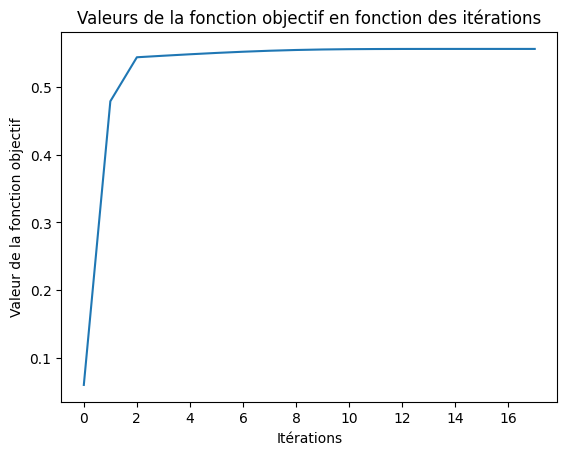

In [8]:
# Initialisation de pi avec des valeurs aléatoires
#pi = torch.rand((2, 2), requires_grad=True)

#pi = project_to_simplex(pi)

pi = torch.tensor([[4/7, 3/7],
                  [0, 1]],requires_grad = True) #on initialise avec le pi solution du problème où epsilon = 0


# Paramètres pour le gradient ascendant
learning_rate = epsilon
max_iterations = 10000
objective_values = []
objective_change_threshold = 1e-6  # Seuil pour la différence de l'objectif

for iteration in range(max_iterations):
    pi = pi.clone().detach().requires_grad_(True)
    
    # Calcul de la fonction objectif et du gradient
    obj = objective(pi, U, V, q, epsilon, nu, mu)
    obj.backward()

    with torch.no_grad():
        pi += learning_rate * pi.grad  # Maximisation
        pi = project_to_simplex(pi)  # Projection sur le simplexe

    # Enregistrer la valeur de l'objectif
    objective_values.append(obj.item())

    # Critère d'arrêt basé sur la variation de la fonction objectif
    if iteration > 0 and abs(objective_values[-1] - objective_values[-2]) < objective_change_threshold:
        print(f"Convergence atteinte en {iteration} itérations")
        break

# Résultats finaux
print("pi optimal : ")
print(pi)
print("Utilitée espérée Sender :")
print(obj.item())

# Tracer l'évolution de la fonction objectif
plt.plot(objective_values)
plt.xlabel("Itérations")
plt.ylabel("Valeur de la fonction objectif")
plt.title("Valeurs de la fonction objectif en fonction des itérations")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

Analysons la valeur du max lorsque epsilon tend vers 0 (c'est-à-dire lorsqu'on "tend vers le premier modèle")

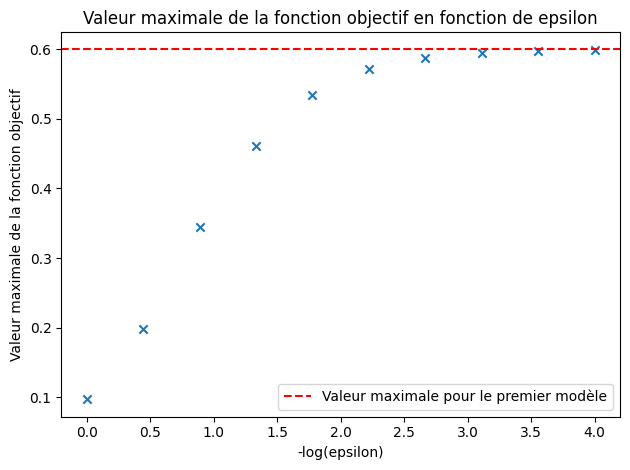

In [9]:
# Constants for the test
max_iterations = 10000
objective_change_threshold = 1e-6  # Threshold for change in the objective
puissances = np.linspace(0, 4, 10)
epsilon_values = [10 ** (-k) for k in puissances]  # Epsilon values to test
max_objective_values = []  # List to store the maximum objective values
norm_differences = []  # List to store the norms

# Initial pi_0 for comparison
pi_0 = torch.tensor([[4/7, 3/7], [0, 1]], dtype=torch.float32)

# Loop over epsilon values
for epsilon_value in epsilon_values:
    # Initialize pi with desired values
    pi = pi_0.clone().detach().requires_grad_(True)
    objective_values = []  # Reset the list of objective values

    # Gradient ascent
    for iteration in range(max_iterations):
        pi = pi.clone().detach().requires_grad_(True)
        
        # Calculate the objective function and gradient
        obj = objective(pi, U, V, q, epsilon_value, nu, mu)
        obj.backward()

        with torch.no_grad():
            pi += epsilon_value * pi.grad  # Maximization
            pi = project_to_simplex(pi)  # Project to the simplex

        # Record the objective value
        objective_values.append(obj.item())

        # Stopping criterion based on the change in objective
        if iteration > 0 and abs(objective_values[-1] - objective_values[-2]) < objective_change_threshold:
            break

    # Record the maximum objective value for this epsilon
    max_objective_values.append(objective_values[-1])

    # Compute the norm of (pi - pi_0) and store
    norm_difference = torch.norm(pi - pi_0).item()
    norm_differences.append(norm_difference)



plt.scatter(np.array(puissances), max_objective_values, marker='x')
plt.axhline(y=0.6, color='red', linestyle='--', label="Valeur maximale pour le premier modèle")  # Red dashed line
plt.xlabel("-log(epsilon)")
plt.ylabel("Valeur maximale de la fonction objectif")
plt.title("Valeur maximale de la fonction objectif en fonction de epsilon")
plt.legend()

plt.tight_layout()
plt.show()

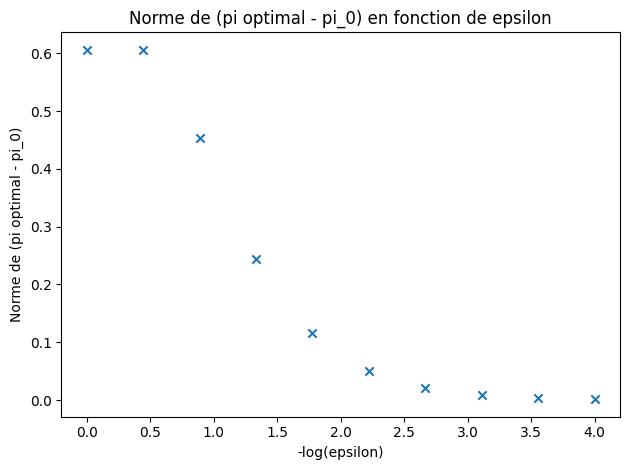

In [10]:
plt.scatter(np.array(puissances), norm_differences, marker='x')
plt.xlabel("-log(epsilon)")
plt.ylabel("Norme de (pi optimal - pi_0)")
plt.title("Norme de (pi optimal - pi_0) en fonction de epsilon")

plt.tight_layout()
plt.show()

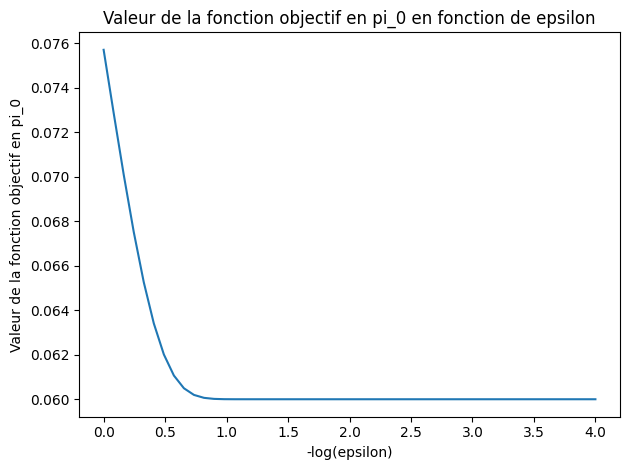

In [11]:
pi = torch.tensor([[4/7, 3/7],
                  [0, 1]])

puissances_2 = np.linspace(0,4,50)
epsilon_values = [10**(-k) for k in puissances_2]
x = []
for epsilon_value in epsilon_values:
    x.append(objective(pi, U, V, q, epsilon_value, nu, mu))
    
plt.plot(np.array(puissances_2), np.array(x))
#plt.axhline(y=0.6, color='red', linestyle='--', label="Valeur maximale pour le premier modèle")  # Red dashed line
plt.xlabel("-log(epsilon)")
plt.ylabel("Valeur de la fonction objectif en pi_0")
plt.title("Valeur de la fonction objectif en pi_0 en fonction de epsilon")
#plt.legend()

plt.tight_layout()
plt.show()

Soit $\pi_{\varepsilon}$ le maximiseur de $f_{\varepsilon}$ obtenu par gradient projeté en initialisant à $\pi_{0}$ le maximiseur du premier modèle. Alors on a
\begin{gather*}
\lim_{\varepsilon \rightarrow 0} f_{\varepsilon}(\pi_{\varepsilon}) = f_{0}(\pi_{0}) \text{ (1er graphique)} \\
\lim_{\varepsilon \rightarrow 0} \pi_{\varepsilon} = \pi_{0} \text{ (2ème graphique)} \\
\text{mais } \lim_{\varepsilon \rightarrow 0} f_{\varepsilon}(\pi_{0}) << f_{0}(\pi_{0}) !! \text{ (3ème graphique)}
\end{gather*}

Pour epsilon très petit, bien que $\pi_{0}$ soit très proche du maximiseur, $f_{\varepsilon}(\pi_{0})$ est loin du max.